
**CNN NEURAL NETWORK & TRANSFER LEARNING WITH FINE TUNING**



**TASK:**
Using the image dataset from the following link (https://drive.google.com/drive/folders/1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq) apply two classification models and compare their results. One model must be a convolutional neural network (CNN), and the second must use a transfer learning algorithm for the same dataset. To achieve maximum points, it's essential to incorporate fine-tuning and tackle any class imbalance concerns. The images are categorized according to their respective labels: Product 1 corresponds to class 1, Product 2 to class 2, and so forth, while Background encompasses background images. These can be utilized for additional preprocessing, if necessary, thus it's crucial to figure out the appropriate method for importing and utilizing the data. You must document your code and give a full explanation about what each block of code does to receive full marks. Save your Jupyter Notebook/Colab Notebook in this format:

Imports:

- TensorFlow and Keras: For building and training the models.
- ImageDataGenerator: For data augmentation.
- Sequential, Conv2D, MaxPooling2D, Flatten, Dense, Dropout: Keras layers to build the CNN and transfer learning models.
- VGG16: Pre-trained model for transfer learning.
- Adam: Optimizer for compiling the models.
- compute_class_weight: To handle class imbalance.
- classification_report, confusion_matrix: To evaluate the model performance.
- EarlyStopping: To prevent overfitting by stopping training early.
- l2: L2 regularization to prevent overfitting.
- numpy: For numerical operations.
- matplotlib: For plotting training history.

In [ ]:
# Import necessary libraries
# TensorFlow and Keras for building and training the models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

In [56]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset path
dataset_path ="/content/drive/My Drive/Colab Notebooks/data/"

<h2>Data preperation<h2>

- Use ImageDataGenerator to apply data augmentation and rescaling.
- Create training and validation data generators using flow_from_directory.
- Compute class weights to handle class imbalance.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


In [ ]:
# Testing data generator (without augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
#validation data

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1520 images belonging to 5 classes.
Found 379 images belonging to 5 classes.


In [ ]:
# Test data generator
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1899 images belonging to 5 classes.


We are not implementing data argumentation on test data.We need it in orginal form

Providing class weights

This ensures that during training, the loss function takes into account the specified weights for each class, thereby mitigating the impact of class imbalance.

In [ ]:

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [ ]:
class_weights

{0: 0.76,
 1: 25.333333333333332,
 2: 0.95,
 3: 0.987012987012987,
 4: 0.6333333333333333}

<h2>CNN Model<h2>

- Build a CNN model with  Dropout layers.
- Compile the model with Adam optimizer and categorical crossentropy loss.
- Train the model with early stopping to prevent overfitting.

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    # Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 36, 36, 64)       

We have added some amount of dropout layer in order to avoid overfitting and to get more generalised model. We have used softmax activation function since i is a multiclass classification

In [ ]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_history = cnn_model.fit(train_generator, epochs=30, validation_data=validation_generator, class_weight=class_weights, callbacks=[early_stopping])


Epoch 1/30
48/48 [==============================] - 118s 2s/step - loss: 2.3221 - accuracy: 0.2520 - val_loss: 1.5730 - val_accuracy: 0.2032
Epoch 2/30
48/48 [==============================] - 109s 2s/step - loss: 1.6003 - accuracy: 0.3178 - val_loss: 1.5876 - val_accuracy: 0.3193
Epoch 3/30
48/48 [==============================] - 109s 2s/step - loss: 1.5968 - accuracy: 0.3796 - val_loss: 1.5764 - val_accuracy: 0.2507
Epoch 4/30
48/48 [==============================] - 106s 2s/step - loss: 1.5060 - accuracy: 0.4355 - val_loss: 1.6321 - val_accuracy: 0.2955
Epoch 5/30
48/48 [==============================] - 110s 2s/step - loss: 1.4759 - accuracy: 0.4658 - val_loss: 1.6905 - val_accuracy: 0.2586
Epoch 6/30
48/48 [==============================] - 110s 2s/step - loss: 1.3147 - accuracy: 0.5151 - val_loss: 1.6010 - val_accuracy: 0.3799


Here we are getting very low accuracy,We trained our data with very low number of epochs.

<h2>Transfer Learning<h2>

- Use VGG16 pre-trained model as the base.
- Add custom layers on top of the VGG16 base.
- Initially freeze the base model layers.
- Compile and train the model.
- Fine-tune the model by unfreezing some layers and training with a lower - learning rate.

In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model

In [ ]:
from tensorflow.keras.regularizers import l2
tl_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [ ]:
base_model.trainable = False
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tl_history = tl_model.fit(train_generator, epochs=5, validation_data=validation_generator, class_weight=class_weights)

Epoch 1/5
48/48 [==============================] - 492s 10s/step - loss: 1.2254 - accuracy: 0.7625 - val_loss: 0.9603 - val_accuracy: 0.5752
Epoch 2/5
48/48 [==============================] - 527s 11s/step - loss: 0.8049 - accuracy: 0.7487 - val_loss: 0.9242 - val_accuracy: 0.5963
Epoch 3/5
48/48 [==============================] - 481s 10s/step - loss: 0.7330 - accuracy: 0.7592 - val_loss: 1.0388 - val_accuracy: 0.5805
Epoch 4/5
48/48 [==============================] - 481s 10s/step - loss: 0.6238 - accuracy: 0.7553 - val_loss: 0.9291 - val_accuracy: 0.6253
Epoch 5/5
48/48 [==============================] - 523s 11s/step - loss: 0.8766 - accuracy: 0.7316 - val_loss: 1.0325 - val_accuracy: 0.5409


After using pre-trained model we could incraese the accuracy.Our model start to initialized with correct weights

In [ ]:
##Fine tuning the model in order to achive more accuracy

Fine tuning the model

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

tl_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
tl_fine_tune_history = tl_model.fit(train_generator, epochs=5, validation_data=validation_generator, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/20
49/49 [==============================] - 37s 709ms/step - loss: 0.6349 - accuracy: 0.8099 - val_loss: 0.9387 - val_accuracy: 0.5984
Epoch 2/20
49/49 [==============================] - 36s 741ms/step - loss: 0.5319 - accuracy: 0.8015 - val_loss: 0.9965 - val_accuracy: 0.5699
Epoch 3/20
49/49 [==============================] - 35s 713ms/step - loss: 0.4967 - accuracy: 0.8499 - val_loss: 0.9977 - val_accuracy: 0.5855
Epoch 4/20
49/49 [==============================] - 36s 728ms/step - loss: 0.4531 - accuracy: 0.8563 - val_loss: 0.9993 - val_accuracy: 0.6036
Epoch 5/20
49/49 [==============================] - 35s 708ms/step - loss: 0.5106 - accuracy: 0.8434 - val_loss: 1.1009 - val_accuracy: 0.5751
Epoch 6/20
49/49 [==============================] - 33s 673ms/step - loss: 0.4445 - accuracy: 0.8441 - val_loss: 0.9474 - val_accuracy: 0.6088


In [ ]:
#After fine tuning the model we could get more accuracy,Still our model is overfitting.We have to adjust the parameters and train the model for more epochs.

<h2>Model Comparision<h2>

In [ ]:
#TO DO-->Train the above 3 model

#accuracy of CNN model
cnn_train_acc = cnn_history.history['accuracy'][-1]
cnn_val_acc = cnn_history.history['val_accuracy'][-1]
print(f'CNN Model - Training Accuracy: {cnn_train_acc:.4f}')
print(f'CNN Model - Validation Accuracy: {cnn_val_acc:.4f}')

#  accuracy of Transfer Learning model before fine-tuning
tl_train_acc = tl_history.history['accuracy'][-1]
tl_val_acc = tl_history.history['val_accuracy'][-1]
print(f'Transfer Learning Model (Before Fine-Tuning) - Training Accuracy: {tl_train_acc:.4f}')
print(f'Transfer Learning Model (Before Fine-Tuning) - Validation Accuracy: {tl_val_acc:.4f}')

#  accuracy of Transfer Learning model after fine-tuning
tl_fine_tune_train_acc = tl_fine_tune_history.history['accuracy'][-1]
tl_fine_tune_val_acc = tl_fine_tune_history.history['val_accuracy'][-1]
print(f'Transfer Learning Model (After Fine-Tuning) - Training Accuracy: {tl_fine_tune_train_acc:.4f}')
print(f'Transfer Learning Model (After Fine-Tuning) - Validation Accuracy: {tl_fine_tune_val_acc:.4f}')


<h2>Evaluvation<h2>

- Plot the training history for both models.
- Evaluate both models using classification reports and confusion matrices.

In [ ]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(title)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

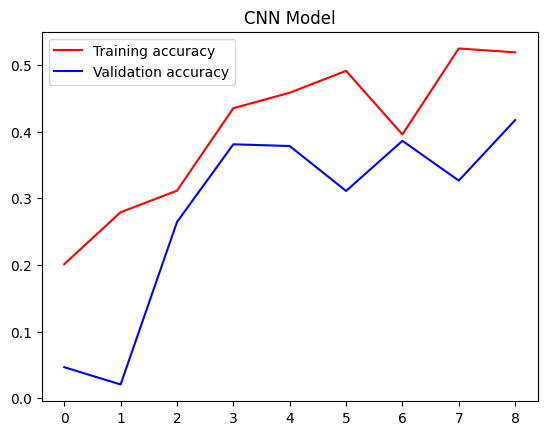

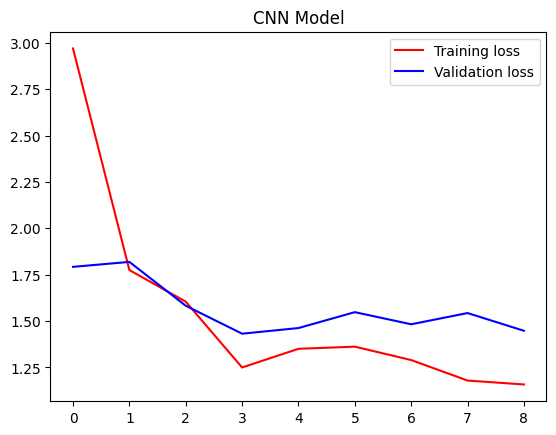

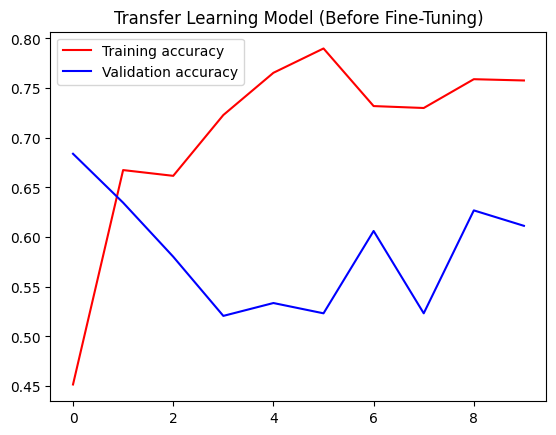

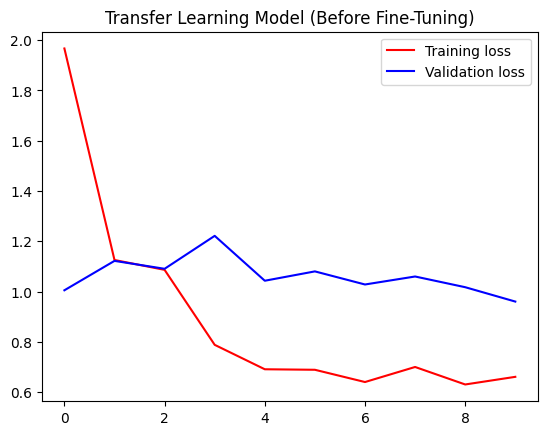

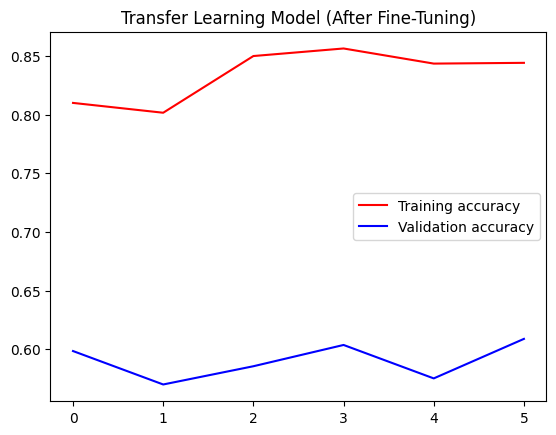

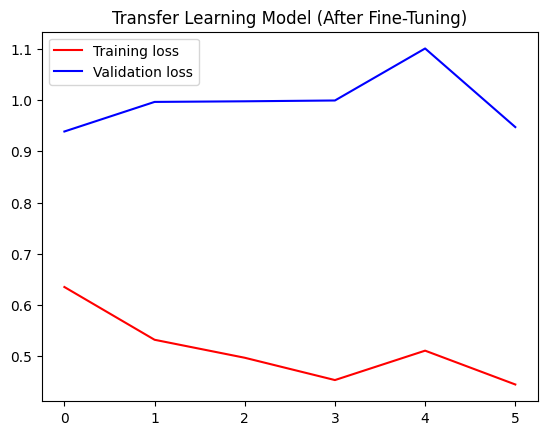

In [ ]:
plot_history(cnn_history, 'CNN Model')
plot_history(tl_history, 'Transfer Learning Model (Before Fine-Tuning)')
plot_history(tl_fine_tune_history, 'Transfer Learning Model (After Fine-Tuning)')

Model performance

In [ ]:
# Model Performance
cnn_predictions = cnn_model.predict(validation_generator)
tl_predictions = tl_model.predict(validation_generator)

13/13 [==============================] - 7s 483ms/step


In [ ]:
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
tl_pred_classes = np.argmax(tl_predictions, axis=1)

In [ ]:
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [ ]:
print('CNN Model Classification Report')
print(classification_report(true_classes, cnn_pred_classes, target_names=class_labels))
print('Confusion Matrix')
print(confusion_matrix(true_classes, cnn_pred_classes))

print('Transfer Learning Model Classification Report (After Fine-Tuning)')
print(classification_report(true_classes, tl_pred_classes, target_names=class_labels))
print('Confusion Matrix')
print(confusion_matrix(true_classes, tl_pred_classes))

CNN Model Classification Report
              precision    recall  f1-score   support

  Background       0.06      0.14      0.09         7
   Product_1       0.23      0.25      0.24       100
   Product_2       0.00      0.00      0.00         2
   Product_3       0.20      0.26      0.23        80
   Product_4       0.16      0.10      0.13        77
   Product_5       0.27      0.23      0.25       120

    accuracy                           0.21       386
   macro avg       0.16      0.16      0.15       386
weighted avg       0.22      0.21      0.21       386

Confusion Matrix
[[ 1  1  1  1  1  2]
 [ 5 25  3 28 13 26]
 [ 1  0  0  0  0  1]
 [ 1 22  2 21 14 20]
 [ 2 25  2 17  8 23]
 [ 6 34  1 39 13 27]]
Transfer Learning Model Classification Report (After Fine-Tuning)
              precision    recall  f1-score   support

  Background       0.00      0.00      0.00         7
   Product_1       0.30      0.15      0.20       100
   Product_2       0.00      0.00      0.00         